In [1]:
import numpy as np
import random

class Ray:
    def __init__(self, origin, direction):
        self.origin = origin  # numpy array
        self.direction = direction / np.linalg.norm(direction)

class Sphere:
    def __init__(self, center, radius, material):
        self.center = center  # numpy array
        self.radius = radius
        self.material = material

    def intersect(self, ray):
        oc = ray.origin - self.center
        a = np.dot(ray.direction, ray.direction)
        b = 2.0 * np.dot(oc, ray.direction)
        c = np.dot(oc, oc) - self.radius*self.radius
        discriminant = b*b - 4*a*c
        if discriminant < 0:
            return None
        else:
            sqrt_disc = np.sqrt(discriminant)
            t1 = (-b - sqrt_disc) / (2.0*a)
            t2 = (-b + sqrt_disc) / (2.0*a)
            if t1 > 1e-4:
                return t1
            if t2 > 1e-4:
                return t2
            return None

class Material:
    def __init__(self, color):
        self.color = color  # numpy array of RGB values

class Scene:
    def __init__(self):
        self.objects = []

    def add(self, obj):
        self.objects.append(obj)

    def intersect(self, ray):
        closest_t = None
        hit_object = None
        for obj in self.objects:
            t = obj.intersect(ray)
            if t and (closest_t is None or t < closest_t):
                closest_t = t
                hit_object = obj
        return closest_t, hit_object

def random_in_hemisphere(normal):
    while True:
        rand_dir = np.random.uniform(-1, 1, 3)
        if np.linalg.norm(rand_dir) >= 1:
            continue
        if np.dot(rand_dir, normal) > 0:
            return rand_dir / np.linalg.norm(rand_dir)

def background(ray):
    t = 0.5 * (ray.direction[1] + 1.0)
    return (1.0 - t) * np.array([1.0, 1.0, 1.0]) + t * np.array([0.5, 0.7, 1.0])

def trace_ray(ray, scene, max_depth=5):
    color = np.array([0.0, 0.0, 0.0])  # Start with black
    attenuation = np.array([1.0, 1.0, 1.0])  # Start with full strength
    for _ in range(max_depth):
        t, obj = scene.intersect(ray)
        if obj is None:
            # No intersection, add background color
            color += attenuation * background(ray)
            break
        else:
            # Compute hit point and normal
            hit_point = ray.origin + t * ray.direction
            normal = (hit_point - obj.center)
            normal = normal / np.linalg.norm(normal)
            # Generate a new random direction in the hemisphere
            direction = random_in_hemisphere(normal)
            # Update the ray
            ray = Ray(hit_point + 1e-4 * normal, direction)
            # Update the attenuation
            attenuation *= obj.material.color
    return color

def render(width, height, samples_per_pixel):
    image = np.zeros((height, width, 3))
    camera_origin = np.array([0.0, 0.0, 0.0])
    aspect_ratio = width / height
    viewport_height = 2.0
    viewport_width = aspect_ratio * viewport_height
    focal_length = 1.0

    # Camera coordinate system
    horizontal = np.array([viewport_width, 0, 0])
    vertical = np.array([0, viewport_height, 0])
    lower_left_corner = camera_origin - horizontal / 2 - vertical / 2 + np.array([0, 0, focal_length])

    #Scene
    scene = Scene()
    # Add a ground sphere
    ground_material = Material(np.array([0.8, 0.8, 0.0]))
    scene.add(Sphere(np.array([0, -100.5, 1]), 100, ground_material))
    # Add a center sphere
    center_material = Material(np.array([0.7, 0.3, 0.3]))
    scene.add(Sphere(np.array([0, 0, 1]), 0.5, center_material))
    # Add a right sphere
    right_material = Material(np.array([0.8, 0.6, 0.2]))
    scene.add(Sphere(np.array([1, 0, 1]), 0.5, right_material))
    # Add a left sphere
    left_material = Material(np.array([0.1, 0.2, 0.5]))
    scene.add(Sphere(np.array([-1, 0, 1]), 0.5, left_material))

    for j in range(height):
        for i in range(width):
            color = np.array([0.0, 0.0, 0.0])
            for _ in range(samples_per_pixel):
                u = (i + random.random()) / (width - 1)
                v = (j + random.random()) / (height - 1)
                direction = lower_left_corner + u * horizontal + v * vertical - camera_origin
                ray = Ray(camera_origin, direction)
                color += trace_ray(ray, scene)
            color = color / samples_per_pixel
            # Gamma correction
            color = np.sqrt(color)
            image[height - j - 1, i] = np.clip(color, 0, 1)
    return image

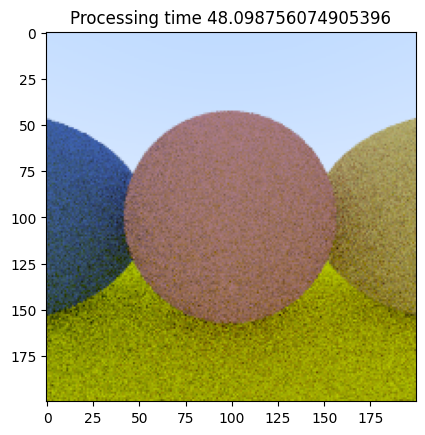

In [2]:
%matplotlib inline

import time
import matplotlib.pyplot as plt

width = 200
height = 200
samples_per_pixel = 10

start_time = time.time()
image = render(width, height, samples_per_pixel)
processing_time = time.time() - start_time
# Convert to uint8 and save image
image = (image * 255).astype(np.uint8)

plt.imshow(image)
plt.title(f"Processing time {processing_time}")
plt.show()